# **FlagGAN1 Model continue: StyleGAN2 ADA -based modification**


*For full project, please visit [AI4M - Project: Part one](https://colab.research.google.com/drive/1SODRk6670HY4V26Be4_A7YkCHXlSGNnR?usp=sharing)*  

*For part two outcome, please visit [AI4M - Project: Part two outcome](https://drive.google.com/drive/folders/1kjYkMsysogk611lZR8jkGb2CWOq9p_mY?usp=sharing)*  


Ref:
* [Transfer Learning Part 2](https://medium.com/dataswati-garage/transfer-learning-part-2-zero-one-few-shot-learning-8d23d2f8583b)
* [This Flag Does Not Exist](https://thisflagdoesnotexist.com/#)
* [Derrick Schultz: StyleGAN2 ada tutorial ](https://www.youtube.com/watch?v=KxXqCsl-z2k)

  

> **This colab is heavily based on [Derrick Schultz: StyleGAN2 ada custom dataset](https://github.com/dvschultz/ml-art-colabs/blob/master/Stylegan2_ada_Custom_Training.ipynb)**  

> **[Command line for StyleGAN2 ada](https://laptrinhx.com/stylegan2-with-adaptive-discriminator-augmentation-ada-official-tensorflow-implementation-233593041/)**  





In [1]:
# Use this line if current numpy does not support StyleGAN2 ada (downgrade is needed)
!pip install numpy==1.19 

     |████████████████████████████████| 14.6 MB 3.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
#access and store result 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install StyleGAN2 ada from server

In [2]:
# select tf 1.x version
%tensorflow_version 1.x
import tensorflow as tf
import os 
from os import mkdir

TensorFlow 1.x selected.


In [3]:
if os.path.isdir("/content/drive/MyDrive/colab-sg2-ada"):
    %cd "/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada"
else:
    #Download the code 
    %cd "/content/drive/MyDrive/"
    !mkdir colab-sg2-ada
    %cd colab-sg2-ada
    !git clone https://github.com/dvschultz/stylegan2-ada
    %cd stylegan2-ada
    !mkdir downloads
    !mkdir datasets

/content/drive/MyDrive
/content/drive/MyDrive/colab-sg2-ada
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 364, done.
remote: Total 364 (delta 0), reused 0 (delta 0), pack-reused 364
Receiving objects: 100% (364/364), 56.17 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (197/197), done.
/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada


In [ ]:
%cd "/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada"
!git config --global user.name "test"
!git config --global user.email "test@test.com"
!git fetch origin
!git checkout origin/main -- train.py

/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada


####Delete non-image file in the dataset and transform dataset to tf.records

In [4]:
dataset = "/content/drive/MyDrive/output/dcgan1000"
dataset_name = "flagGAN_test01"

In [5]:
from fastai.vision import verify_images
verify_images(dataset, delete=True)
from PIL import Image
from tqdm import tqdm
import shutil

In [6]:
# create .tfrecords file from input pathway
!python dataset_tool.py create_from_images ./datasets/{dataset_name} {dataset}

Loading images from "/content/drive/MyDrive/output/dcgan1000"
Creating dataset "./datasets/flagGAN_test01"
dataset_tool.py:97: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
Added 1008 images.


## Training a custom model with dataset

### Preparation for Transfer Learning



* download pretrained model weight
* customize based on input image size



Reference: 
> [Harnick Khera Public Notebook](https://github.com/Hephyrius/Stylegan2-Ada-Google-Colab-Starter-Notebook)

> [Nivida Transfer Learning resource for StyleGAN 2 ADA](https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/)



In [ ]:
"""
#copy and download pretrained model weight 
!wget http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-horse-config-f.pkl


!git clone https://github.com/aydao/stylegan2-surgery.git
%cd stylegan2-surgery
!python create_initial_network_pkl.py --width 256 --height 256
!python copy_weights.py /content/stylegan2-ffhq-config-f.pkl /content/stylegan2-surgery/network-initial-config-f-256x256-0.pkl --output_pkl /content/surgery_output.pkl

"""

--2022-03-14 16:12:22--  http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-horse-config-f.pkl
Resolving d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)... 52.222.196.222, 52.222.196.164, 52.222.196.42, ...
Connecting to d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)|52.222.196.222|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 357418027 (341M) [application/x-www-form-urlencoded]
Saving to: ‘stylegan2-horse-config-f.pkl.3’

stylegan2-horse-con 100%[===================>] 340.86M   157MB/s    in 2.2s    

2022-03-14 16:12:25 (157 MB/s) - ‘stylegan2-horse-config-f.pkl.3’ saved [357418027/357418027]



### Check what parameters and argus can be modified in pre-trained model

In [7]:
%cd "/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada" 

/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada


In [8]:
!python train.py --help 

usage: train.py [-h] --outdir DIR [--gpus INT] [--snap INT] [--seed INT] [-n]
                --data PATH [--res INT] [--mirror BOOL] [--mirrory BOOL]
                [--use-raw BOOL] [--metrics LIST] [--metricdata PATH]
                [--cfg {auto,11gb-gpu,11gb-gpu-complex,24gb-gpu,24gb-gpu-complex,48gb-gpu,48gb-2gpu,stylegan2,paper256,paper512,paper1024,cifar,cifarbaseline,aydao}]
                [--lrate FLOAT] [--ttur BOOL] [--gamma FLOAT] [--nkimg INT]
                [--kimg INT] [--topk FLOAT] [--aug {noaug,ada,fixed,adarv}]
                [--p FLOAT] [--target TARGET] [--initstrength INITSTRENGTH]
                [--augpipe {blit,geom,color,filter,noise,cutout,bg,bgc,bgcf,bgcfn,bgcfnc}]
                [--cmethod {nocmethod,bcr,zcr,pagan,wgangp,auxrot,spectralnorm,shallowmap,adropout}]
                [--dcap FLOAT] [--resume RESUME] [--freezed INT]

Train a GAN using the techniques described in the paper
"Training Generative Adversarial Networks with Limited Data".

optional

**Set up new args and parameters for training**


* dataset_name should be exactly the same 
* the frequency of generating samples and checkpoint .pkl file should consider 2,4,8 based on GPU status 




In [11]:
dataset_name = "flagGAN_test01"
snapshot_count = 2
mirrored = True #left and right mirrored 
mirroredY = True #top and bottom mirrored 
metric_list = None #Paper recommends "Kid50k_full" 
cfg = "11gb-gpu"

#argumentation fine-tuning
augs = "bg" #argumentation: blit, geom, color, filter, noise, cutout


# TRANSFER LEARNING 
"""
1. for first time running, set ffhq(+resolution): 256, 512, 1024
2. for resuming and using checkpoint .pkl file, set the path to the lastest file 
3. this is the third training as the second runtime was disconnected after 2.5 hours (see report)
"""

#resume from first testrun, as the result meets the expectation
resume_from = "/content/drive/MyDrive/colab-sg2-ada/stylegan2-ada/results/00000-flagGAN_test01-mirror-mirrory-11gb-gpu-bg-resumecustom/network-snapshot-000048.pkl"  
#freezed = None #freeze discrminator layers, default is 0

**Training Command** 


* ~ 12-15 min per tick
* default 50 ticks
* First test run takes approx. 8.5 hours
* Second test run takes approx. 2.5 hours
* Third test run takes approx. 2.2 hours 
* Fourth test run takes approx. 8.2 hours in two times 



> ***Second testrun shows a hint of [mode collapse](https://machinelearning.wtf/terms/mode-collapse/)***









In [ ]:
!python train.py --outdir ./results --snap={snapshot_count} --cfg={cfg} --data=./datasets/{dataset_name} --augpipe={augs} --mirror={mirrored} --mirrory={mirroredY} --metrics={metric_list} --resume={resume_from} 

tcmalloc: large alloc 4294967296 bytes == 0x55fa1669c000 @  0x7f52ad8b4001 0x7f52aaab767f 0x7f52aab07978 0x7f52aab0b9a7 0x7f52aaba9fd3 0x55fa0fe02424 0x55fa0fe02120 0x55fa0fe76b80 0x55fa0fe7166e 0x55fa0fe0436c 0x55fa0fe457b9 0x55fa0fe426d4 0x55fa0fe02c29 0x55fa0fe76e61 0x55fa0fe7102f 0x55fa0fd42e2b 0x55fa0fe73633 0x55fa0fe7102f 0x55fa0fd42e2b 0x55fa0fe73633 0x55fa0fe7166e 0x55fa0fd42e2b 0x55fa0fe73633 0x55fa0fe039da 0x55fa0fe71eae 0x55fa0fe7102f 0x55fa0fe70d43 0x55fa0ff3b302 0x55fa0ff3b67d 0x55fa0ff3b526 0x55fa0ff131d3
tcmalloc: large alloc 4294967296 bytes == 0x55fb1669c000 @  0x7f52ad8b21e7 0x7f52aaab759e 0x7f52aab07a9b 0x7f52aab0817f 0x7f52aaba9ed3 0x55fa0fe02424 0x55fa0fe02120 0x55fa0fe76b80 0x55fa0fe7102f 0x55fa0fe03aba 0x55fa0fe72cd4 0x55fa0fe7102f 0x55fa0fe03aba 0x55fa0fe72cd4 0x55fa0fe7102f 0x55fa0fe03aba 0x55fa0fe72cd4 0x55fa0fe039da 0x55fa0fe71eae 0x55fa0fe7102f 0x55fa0fe03aba 0x55fa0fe762c0 0x55fa0fe7102f 0x55fa0fe03aba 0x55fa0fe72cd4 0x55fa0fe7166e 0x55fa0fe0436c 0x55fa0fe4

## Display Result

###Create a gif: from first, second and third training outcome

ref: [Imageio document](https://imageio.readthedocs.io/en/stable/examples.html)

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
datafile_path = '/content/drive/MyDrive/stylegan2-ada-output/output_all'
output_file = '/content/drive/MyDrive/stylegan2-ada-output/output_gif/training_all.gif'

In [ ]:
files = os.listdir(datafile_path)
images_path = [os.path.join(datafile_path,file) for file in files]

In [ ]:
"""
fps are the frames per second
1. 16-18 old school movie style
2. 24 standard video 

"""
images = []
for img in images_path:
    if img.endswith('jpg'):
      images.append(imageio.imread(img))
imageio.mimsave(output_file, images, fps= 3)

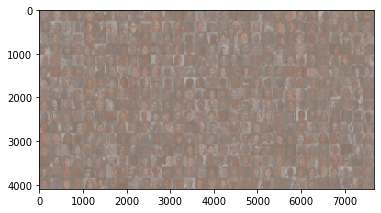

In [ ]:
img = mpimg.imread(output_file)
plt.imshow(img)